# Bird Species Image Classification



## Step 0: Import Libraries

We will start the project by importing necessary libraries.

In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import torchvision
from torchvision import transforms
from tqdm.notebook import tqdm
from torchvision.utils import make_grid
import os
from sklearn.model_selection import train_test_split
import torch.backends.cudnn as cudnn

In [5]:
import torch

# 检查是否支持 GPU
if torch.cuda.is_available():
    print("GPU is available!")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("GPU is not available.")


GPU is available!
Using GPU: NVIDIA GeForce RTX 3080


## Step 1: Data exploration and cleaning

When using other people's data to train our computer vision model, the very first step should be to familiarize oneself with how the data is organized. Specifically, our dataset folder has three subfolders: **test, train, and valid**. Inside these three subfolders, there are 525 invidiual subsubfolders for each bird species. We can see this by loading the ```birds.csv``` file using ```pandas``` which we already imported as ```pd```. Specifically the ```read_csv()``` method:

In [6]:
df = pd.read_csv("all_data.csv")
df.head()


,filepaths,labels,class,data set
0,data\class_36\118.jpg,class_36,31,train
1,data\class_144\94.jpg,class_144,117,train
2,data\class_47\56.jpg,class_47,40,train
3,data\class_136\48.jpg,class_136,109,train
4,data\class_110\122.jpg,class_110,86,train


Now that we have loaded the csv file given, let us see how many images do we have in the test, train and valid subfolders within the dataset parent folder.

In [7]:
import pandas as pd

# 读取 CSV 文件
file_path = "all_data.csv"
df = pd.read_csv(file_path)

# 如果有错误标签，可以进行修改
df['labels'] = df['labels'].str.replace('PARAKETT  AKULET', 'PARAKETT  AUKLET')

# 检查文件路径是否正确（显示前几行）
print(df.head())

# 统计每个数据集（train, valid, test）中的样本数量
train_imgs_count = df['data set'].value_counts().get('train', 0)
valid_imgs_count = df['data set'].value_counts().get('valid', 0)
test_imgs_count = df['data set'].value_counts().get('test', 0)

# 打印训练集、测试集和验证集的样本数量
print(f"Number of train images: {train_imgs_count}")
print(f"Number of valid images: {valid_imgs_count}")
print(f"Number of test images: {test_imgs_count}")

# 将数据集拆分为 train, valid 和 test
train_df = df[df['data set'] == 'train']
valid_df = df[df['data set'] == 'valid']
test_df = df[df['data set'] == 'test']

# 打印各个数据集的大小
print(f"Training set: {train_df.shape[0]} samples")
print(f"Validation set: {valid_df.shape[0]} samples")
print(f"Test set: {test_df.shape[0]} samples")

# 显示验证集的前几行
print(valid_df.head())


                filepaths     labels  class data set
0   data\class_36\118.jpg   class_36     31    train
1   data\class_144\94.jpg  class_144    117    train
2    data\class_47\56.jpg   class_47     40    train
3   data\class_136\48.jpg  class_136    109    train
4  data\class_110\122.jpg  class_110     86    train
Number of train images: 22351
Number of valid images: 4791
Number of test images: 4790
Training set: 22351 samples
Validation set: 4791 samples
Test set: 4790 samples
                    filepaths     labels  class data set
22351    data\class_53\45.jpg   class_53     45    valid
22352   data\class_160\69.jpg  class_160    130    valid
22353  data\class_174\169.jpg  class_174    140    valid
22354   data\class_95\160.jpg   class_95     73    valid
22355  data\class_158\183.jpg  class_158    128    valid


In [8]:
# data_dir = "/kaggle/input/100-bird-species/"
# print(df.shape)
# # limit the number of classes to most frequent 20 classes
# num_classes = 525
# df = df[df["labels"].isin(df["labels"].value_counts().index[:num_classes])]
# print(df.shape)

Great! The numbers match those mentioned in the [data card](https://www.kaggle.com/datasets/gpiosenka/100-bird-species). However we got these numbers from the csv file. What if because of minor oversights, there are discrepancies in the csv file vs the actual existence of these files? Let's quickly check

In [9]:
# collect missing files
import os
missing_files = []
data_dir = ""
for i in tqdm(df["filepaths"], total=len(df)):
    if not os.path.exists(data_dir + i):
        missing_files.append(i)

# print how many missing files
print(len(missing_files))

  0%|          | 0/31932 [00:00<?, ?it/s]

0


Our suspicion was indeed correct! There are 165 files missing in the parent data folder: ``` /kaggle/input/100-bird-species```. So we will now remove the missing entries in our dataframe ```df``` in order for our model to train smoothly.

In [10]:
print(f'dataframe shape before removing the missing files: {df.shape}')
# remove the missing files
df = df[~df["filepaths"].isin(missing_files)]
print(f'dataframe shape after removing the missing files: {df.shape}')

dataframe shape before removing the missing files: (31932, 4)
dataframe shape after removing the missing files: (31932, 4)


## Step 2: Data preparation for model
Machine learning models are trained on datasets in order to be able to learn patterns in data. Here our goal is to transform our image dataset into numeric matrices. The most important step here is to ensure that the model is being trained on data that actually represents the samples which in our case are images of birds. Python provides libraries such as Python Image Library (PIL) which provides the ```Image.open()``` method that lets us represent images with matrices. Since we have 84635 images of 525 bird species, applying the ```Image.open()```  function on every image individually would be tedious and/or impossible. So 

Since our dataset is already divided into test, train, and validation sets, we can begin data preparation for modeling by creating three different dataframes for each set.

In [1]:
# # df dataset has "data set" column which is "train", "test" and "valid" lets split the data into train, test and valid
# train_df = df[df['data set'] == 'train']
# val_df = df[df['data set'] == 'valid']
# test_df = df[df['data set'] == 'test']

# print(train_df)


NameError: name 'df' is not defined

These three dataframes: ```train_df```, ```test_df```, and ```valid_df``` will be the input parameters through which an ```ImageDataset``` object will build dataloaders. Let's build this dataloader class. Our custom```ImageDataset``` class must implement three functions: ```__init__(self, df, transform=None)```,  ```__len__(self)``` and ```__getitem__(self, index)``` . Let us discuss the purposes of these three functions:


### ```__init__(self, df, transform=None)```

This function is run once when instantiating the ```ImageDataset``` object. Since three dataframes we have created have the paths to our images and their labels, passing the relevant dataframe would be sufficient in initializing the directory containing the images and their annotations/labels. Another parameter is the transforms which we will discuss shortly. 


### ```__len__(self)```

This function returns the number of samples in our dataset.


### ```__getitem__(self, index)```

This function loads and returns a sample from the dataset at the given index ```index```. Based on the index, it identifies the image’s location on disk,  opens and identifies the image file at the given index, and then applies the transforms provided by us.

In [12]:
class ImageDataSet(torch.utils.data.Dataset):
    def __init__(self,df, transform=None):
        super().__init__()
        self.df = df
        self.transform = transform
        self.labels2idx = {label: i for i, label in enumerate(df["labels"].unique())}


    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        row = self.df.iloc[index]
        image = Image.open(data_dir +  row["filepaths"])

        if self.transform:
            image = self.transform(image)
#         image = image / 255.0
        return image, self.labels2idx[row["labels"]]



# for sample, image in train_loader:
#     print(image.shape)


In [13]:
# 数据增强和预处理
train_transform = transforms.Compose([
    transforms.Resize((512, 512)),  # 统一到 512x512
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(),
    transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    transforms.RandomRotation(degrees=20),
    transforms.ToTensor()
])

valid_transform = transforms.Compose([
    transforms.Resize((512, 512)),  # 统一到 512x512
    transforms.ToTensor()
])

In [14]:
train_dataset = ImageDataSet(train_df, transform=train_transform)
valid_dataset = ImageDataSet(valid_df, transform=valid_transform)
test_dataset = ImageDataSet(test_df, transform=valid_transform)
print(len(train_dataset))
batch_size = 16
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, num_workers=4, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=4, pin_memory=True)
print(len(valid_loader))

22351
300


In [15]:
# import os
# from PIL import Image

# source_dir = "data"  # 替换为实际数据集路径

# # 遍历所有图片，检查模式并转换
# cmd = 0
# for root, dirs, files in os.walk(source_dir):
#     for file in files:
#         img_path = os.path.join(root, file)
#         cmd += 1
#         try:
#             with Image.open(img_path) as img:
#                 if img.mode != 'RGB':
#                     img = img.convert('RGB')
#                     img.save(img_path)  # 覆盖保存为 RGB 格式的 JPG
#                     print(f"已将 {img_path} 转换为 RGB 格式")
#         except Exception as e:
#             print(f"无法处理图片 {img_path}: {e}")
#         print(f"已处理 {cmd} 张图片", end='\r')


In [ ]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

print("开始迭代 train_loader...")

for batch_idx, (images, labels) in enumerate(train_loader):
    print(f"处理第 {batch_idx + 1} 个 batch")
    
    # 检查 images 和 labels 的形状
    print(f"images.shape: {images.shape}")
    print(f"labels.shape: {labels.shape}")
    
    # 确保图像在 CPU 上
    images = images.cpu()
    print("图像已移动到 CPU")
    
    # 设置图像显示
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    
    # 将 images 的 batch 进行 grid 显示
    grid_image = make_grid(images[:4], nrow=2)
    print("Grid 图像已生成")
    
    # 检查生成的 grid_image 的形状
    print(f"grid_image.shape: {grid_image.shape}")
    
    ax.imshow(grid_image.permute(1, 2, 0))  # 只显示前4张图片
    print("开始显示图像")
    plt.show()
    print("图像显示完毕")
    break  # 仅处理第一个 batch

print("train_loader 迭代完毕")


开始迭代 train_loader...


In [13]:
for images, labels in valid_loader:
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, 4).permute(1,2,0))
    break


In [14]:
import torchvision.models as models

model = models.resnet50()
fc_in_features = model.fc.in_features
model.fc = nn.Linear(fc_in_features, 525)


# model = models.vgg16(pretrained = True)

# ### Modifying last few layers and no of classes
# # NOTE: cross_entropy loss takes unnormalized op (logits), then function itself applies softmax and calculates loss, so no need to include softmax here
# model.classifier = nn.Sequential(
#     nn.Linear(25088, 4096, bias = True),
#     nn.ReLU(inplace = True),
#     nn.Dropout(0.4),
#     nn.Linear(4096, 2048, bias = True),
#     nn.ReLU(inplace = True),
#     nn.Dropout(0.4),
#     nn.Linear(2048, num_classes),
# )


In [15]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
model = model.to(device)
print(device)

cuda


In [16]:
def calc_accuracy(true,pred):
    pred = F.softmax(pred, dim = 1)
    true = torch.zeros(pred.shape[0], pred.shape[1]).scatter_(1, true.unsqueeze(1), 1.)
    acc = (true.argmax(-1) == pred.argmax(-1)).float().detach().numpy()
    acc = float(acc.sum() / len(acc))
    return round(acc, 4)

In [17]:
print(f"Validation loader size: {len(valid_loader)}")


Validation loader size: 300


In [18]:
num_train_samples = len(train_loader.dataset)
num_valid_samples = len(valid_loader.dataset)
print(f"Number of training datapoints: {num_train_samples}")
print(f"Number of validation datapoints: {num_valid_samples}")

print(model)


Number of training datapoints: 22351
Number of validation datapoints: 4791
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample

In [ ]:
# 启用cudnn.benchmark以加速卷积操作
cudnn.benchmark = True

criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 100  # 训练500次

history = {
    "train_loss": [],
    "train_acc": [],
    "valid_loss": [],
    "valid_acc": []
}

best_loss = np.inf
best_acc = 0
for epoch in range(1, num_epochs + 1):  # 从1开始计数
    train_loss = 0
    train_acc = 0
    model.train()
    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criteria(outputs, labels)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        train_acc += calc_accuracy(labels.cpu(), outputs.cpu())
        
    train_loss = train_loss / len(train_loader)
    train_acc = train_acc / len(train_loader)
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)

    valid_loss = 0
    valid_acc = 0
    model.eval()
    for images, labels in tqdm(valid_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criteria(outputs, labels)
        valid_loss += loss.item()
        valid_acc += calc_accuracy(labels.cpu(), outputs.cpu())
        
    valid_loss = valid_loss / len(valid_loader)
    valid_acc = valid_acc / len(valid_loader)

    history["valid_loss"].append(valid_loss)
    history["valid_acc"].append(valid_acc)

    if epoch % 5 == 0:
        print(f"Saving model at epoch {epoch}")
        torch.save(model.state_dict(), f"model_epoch_{epoch}.pt")
        
    if valid_acc > best_acc:
        best_acc = valid_acc
        print(f"Saving the best model at epoch {epoch}")
        torch.save(model.state_dict(), "best_model.pt")
    
    print(f"Epoch: {epoch} Train Loss: {train_loss:.2f} Train Acc: {train_acc:.2f} Val Loss: {valid_loss:.2f} Val Acc: {valid_acc:.2f}")

  0%|          | 0/1397 [00:00<?, ?it/s]

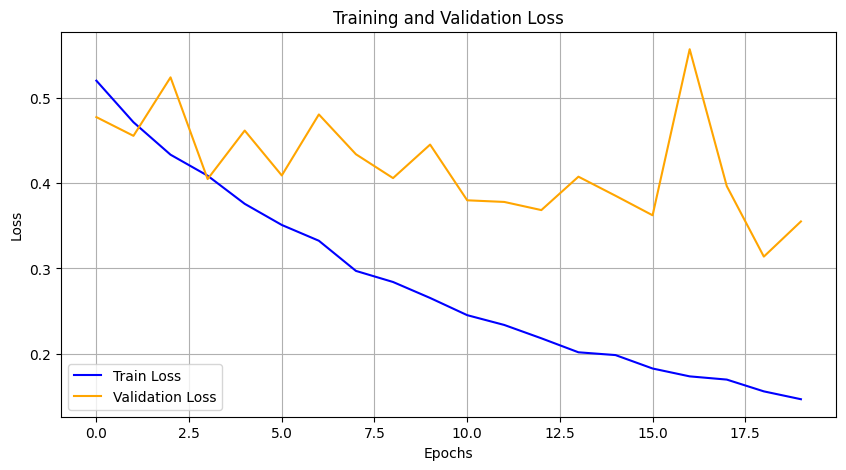

In [42]:
# 绘制损失曲线
plt.figure(figsize=(10, 5))
plt.plot(history["train_loss"], label="Train Loss", color='blue')
plt.plot(history["valid_loss"], label="Validation Loss", color='orange')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

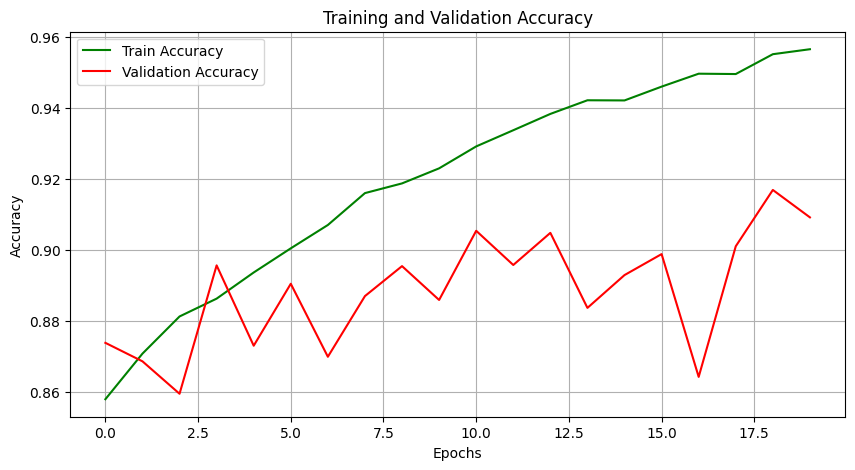

In [43]:
# 绘制准确率曲线
plt.figure(figsize=(10, 5))
plt.plot(history["train_acc"], label="Train Accuracy", color='green')
plt.plot(history["valid_acc"], label="Validation Accuracy", color='red')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [50]:
torch.cuda.empty_cache()
del model
del optimizer
del train_loader, valid_loader
torch.cuda.empty_cache()


In [1]:
# test the model
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
test_acc = 0
for images, labels in tqdm(test_loader):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += calc_accuracy(labels.cpu(), outputs.cpu())
test_acc = test_acc / len(test_loader)
print(f"Test Acc: {test_acc}")

NameError: name 'model' is not defined

In [20]:
import pickle 

outfile = 'resnet50_model.pkl'

with open(outfile, 'wb') as pickle_file:
    pickle.dump(torch.load("best_model.pt"), pickle_file)

In [21]:
from fastai.vision.all import *
import fastai

learn = load_learner('/kaggle/working/resnet50_model.pkl')
def classify_image(img):
    pred, idx, prbs = learn.predict(img)
    dict_all = dict(zip(categories, map(float, prbs)))
    return dict(sorted(dict_all.iteritems(), key=operator.itemgetter(1), reverse=True)[:5])

print(classify_image('/kaggle/input/100-bird-species/test/ABYSSINIAN GROUND HORNBILL/4.jpg'))

RuntimeError: Invalid magic number; corrupt file?